In [8]:
import os
from matplotlib.colors import LinearSegmentedColormap
import pickle
import matplotlib.pyplot as plt
import uuid


new_dir = '/home/ma/ma_ma/ma_lineuman/Interpretable-Deep-Fake-Detection/results'
if os.path.exists(new_dir):
    os.chdir(new_dir)
    print("Changed working directory to:", os.getcwd())
else:
    print("Directory does not exist")

Changed working directory to: /pfs/data6/home/ma/ma_ma/ma_lineuman/Interpretable-Deep-Fake-Detection/results


In [3]:
def visualize_and_save(img_np, heatmap, true_fake_pos, weighted_guessed_fake_position, weighted_localization_score, unweighted_localization_score, unweighted_guessed_fake_position, grid_split, model_prediction, save_folder="results", file_prefix="visualization"):
    """
    Visualisiert das Originalbild und die Heatmap nebeneinander und speichert die Abbildung unter einem eindeutigen Dateinamen.
    """
    print(f"[DEBUG] Visualizing heatmap with shape: {heatmap.shape}")

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

    # --- Linke Seite: Originalbild ---
    ax1.imshow(img_np)
    ax1.set_title("Original Image")
    ax1.axis("off")

    colors = ["white", "red"]
    custom_cmap = LinearSegmentedColormap.from_list("white_to_red", colors)
    
    # --- Rechte Seite: Heatmap ---
    ax2.imshow(heatmap, cmap=custom_cmap)
    ax2.set_title("Heatmap")
    ax2.axis("off")

    # Überschrift mit Anmerkungen
    fig.suptitle(
        f"True Fake Pos: {true_fake_pos}, weighted Guess: {weighted_guessed_fake_position}, unweighted Guess: {unweighted_guessed_fake_position}\n"
        f"Intensity-Weighted Localization Score: {weighted_localization_score:.4f}, Unweighted Localization Score: {unweighted_localization_score:.4f}, Modelprediction: {model_prediction}"
    )

    plt.tight_layout()

    # Sicherstellen, dass der Speicherordner existiert.
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)

    # Eindeutigen Dateinamen generieren: Prefix, echte/erratene Position und ein zufälliger UUID-Teil.
    unique_id = uuid.uuid4().hex[:8]
    filename = f"{file_prefix}_{true_fake_pos}_{unweighted_guessed_fake_position}_{unique_id}.png"
    filepath = os.path.join(save_folder, filename)

    # Abbildung speichern.
    plt.savefig(filepath)
    print(f"Saved visualization to {filepath}")

    plt.show()

########################################################################################################################################################################

Visulize top 10 grid per model

In [ ]:
results_file = os.path.join("/pfs/work9/workspace/scratch/ma_tischuet-team_project_explainable_deepfakes/resultsGPG","resnet34_test_res_gradcam_config","3x3","results_by_threshold.pkl")
print("Results file path:", os.path.abspath(results_file))

with open(results_file, "rb") as f:
    results = pickle.load(f)

# 2) pick out only the threshold==0 entries
#    (we saved threshold=None as 0 in the dict keys)
threshold0 = results.get(0, [])

# 3) sort by unweighted localization score and take top 10
top10 = sorted(
    threshold0,
    key=lambda r: r.get("weighted_localization_score", 0),
    reverse=True
)[:10]

grid_split = 3  # your grid size

# 4) visualize
for rank, best in enumerate(top10, 1):
    img_np   = best["original_image"]
    heatmap  = best["heatmap"]
    true_fp  = best["true_fake_position"]
    wg_fp    = best["weighted_guessed_fake_position"]
    wg_score = best["weighted_localization_score"]
    uw_score = best["unweighted_localization_score"]
    uw_fp    = best["unweighted_guess_fake_position"]
    pred     = best["model_prediction"]
    # threshold is always 0 here

    print(f"{rank}. wg_score={wg_score:.3f}, true={true_fp}, wg_guess={wg_fp}")

    visualize_and_save(
        img_np,
        heatmap,
        true_fp,
        wg_fp,
        wg_score,
        uw_score,
        uw_fp,
        grid_split,
        pred,
        save_folder="results/top10_thresh0",
        file_prefix=f"#{rank}"
    )

###################################################################################################################################################################################################

Visulize all Grids !!!!!Warning!!!!!!

In [ ]:
with open(results_file, "rb") as f:
    results = pickle.load(f)

for threshold, result_list in results.items():
    for result in result_list:
        path = result.get("path")
        img_np = result.get("original_image")
        heatmap = result.get("heatmap")
        true_fake_pos = result.get("true_fake_position")
        weighted_guessed_fake_position = result.get("weighted_guessed_fake_position")
        unweighted_guess_fake_position = result.get("unweighted_guess_fake_position")
        model_prediction = result.get("model_prediction")
        weighted_localization_score = result.get("weighted_localization_score", 0.0)
        unweighted_localization_score = result.get("unweighted_localization_score", 0.0)

        grid_split = 3  # oder 4 oder was auch immer du verwendet hast
        print(f"[DEBUG] img_np shape after transpose: {img_np.shape}, dtype: {img_np.dtype}, max: {img_np.max()}")


        
        print(f"Threshold {threshold} | Weighted localization score: {weighted_localization_score:.2f} | weighted Guessed: {weighted_guessed_fake_position} | True: {true_fake_pos}")
        visualize_and_save(img_np, heatmap, true_fake_pos, weighted_guessed_fake_position, weighted_localization_score, unweighted_localization_score, unweighted_guess_fake_position, grid_split, model_prediction, save_folder="results", file_prefix="visualization")


In [ ]:
import os
import glob
import torch
import matplotlib.pyplot as plt

# ─── CONFIG ────────────────────────────────────────────────────
# point this to your actual grids folder:
grid_dir = "resnet34_default/3x3"

# which grid to display? 0‐based index into sorted list of .pt files
grid_index = 0
# ───────────────────────────────────────────────────────────────

# find all the .pt files
grid_paths = sorted(glob.glob(os.path.join(grid_dir, "*.pt")))
if not grid_paths:
    raise FileNotFoundError(f"No .pt files found in {grid_dir!r}")

path = grid_paths[grid_index]
print("Showing grid:", os.path.basename(path))

# load the tensor
grid_tensor = torch.load(path, map_location="cpu")

# remove any leading batch‐dim
# expected shape now: [C, H, W]
if grid_tensor.ndim == 4 and grid_tensor.size(0) == 1:
    grid_tensor = grid_tensor.squeeze(0)
elif grid_tensor.ndim not in (3,):
    raise ValueError(f"Unexpected tensor shape {tuple(grid_tensor.shape)}")

#if it has >3 channels (BCoS gives 6), keep only RGB
#if grid_tensor.size(0) > 3:
    #img = grid_tensor[:3]
#else:
img = grid_tensor

# move to HWC and numpy
img = img.permute(1, 2, 0).numpy()

# normalize to [0,1] for display
img = (img - img.min()) / (img.max() - img.min() + 1e-8)

# plot
plt.figure(figsize=(6,6))
plt.imshow(img)
plt.axis("off")
plt.title(os.path.basename(path))
plt.show()


In [ ]:
with open(results_file, "rb") as f:
    results = pickle.load(f)

for threshold, result_list in results.items():
    for result in result_list:
        path = result.get("path")
        img_np = result.get("original_image")
        heatmap = result.get("heatmap")
        true_fake_pos = result.get("true_fake_position")
        guessed_fake_pos = result.get("guessed_fake_position")
        model_prediction = result.get("model_prediction")
        accuracy = result.get("accuracy", 0.0)

        grid_split = 3  # oder 4 oder was auch immer du verwendet hast

        print(f"Threshold {threshold} | Accuracy: {accuracy:.2f} | Guessed: {guessed_fake_pos} | True: {true_fake_pos}")
        visualize_and_save(img_np, heatmap, true_fake_pos, guessed_fake_pos, accuracy, grid_split, model_prediction)

################################################################################################################################################################################################################################################################################################################################################################

Visulization of mean accuracies

In [10]:
import os
import pickle
import numpy as np

# ─────────── CONFIG ───────────
models = [
    "resnet34_bcos_v2_test_MPG_bcos_2_5",
    #"resnet34_bcos_v2_test_MPG_bcos_1_75",
    "resnet34_bcos_v2_test_MPG_bcos_1_25",
    #"resnet34_test_res_lime_config",
    "resnet34_test_MPG_gradcam",
    "resnet34_test_MPG_xgrad",
    "resnet34_test_MPG_grad++",
    "resnet34_test_MPG_layergrad",
    "vit_bcos_test_MPG_bcos_1_25",
    "vit_bcos_test_MPG_bcos_1_75",
    "vit_bcos_test_MPG_bcos_2_5"
    # ggf. weitere Modelle hier
]
results_base = "/pfs/work9/workspace/scratch/ma_tischuet-team_project_explainable_deepfakes/resultsMPG/"
#grid_subpath  = "MaskPointingGame"
threshold_key = 0  # unser „no threshold“, wird im Dict als 0 gespeichert
# ───────────────────────────────

print("| Model                                           | Weighted avg | Unweighted avg |")
print("|:------------------------------------------------|------------:|---------------:|")

for m in models:
    pkl = os.path.join(results_base, m, "MaskPointingGame/results_by_threshold.pkl")
    with open(pkl, "rb") as f:
        res = pickle.load(f)
    entries = res.get(threshold_key, [])
    if not entries:
        print(f"| {m:48} |      n/a    |       n/a     |")
        continue

    w_scores = [e["weighted_localization_score"]   for e in entries]
    u_scores = [e["unweighted_localization_score"] for e in entries]
    w_mean = np.mean(w_scores)
    u_mean = np.mean(u_scores)

    print(f"| {m:48} | {w_mean:12.4f} | {u_mean:14.4f} |")
    print 

| Model                                           | Weighted avg | Unweighted avg |
|:------------------------------------------------|------------:|---------------:|
| resnet34_bcos_v2_test_MPG_bcos_2_5               |       0.8408 |         0.2639 |
| resnet34_bcos_v2_test_MPG_bcos_1_25              |       0.7497 |         0.2666 |
| resnet34_test_MPG_gradcam                        |       0.5518 |         0.3533 |
| resnet34_test_MPG_xgrad                          |       0.5540 |         0.3511 |
| resnet34_test_MPG_grad++                         |       0.5552 |         0.3523 |
| resnet34_test_MPG_layergrad                      |       0.5549 |         0.3527 |
| vit_bcos_test_MPG_bcos_1_25                      |       0.8545 |         0.2599 |
| vit_bcos_test_MPG_bcos_1_75                      |       0.7398 |         0.2591 |
| vit_bcos_test_MPG_bcos_2_5                       |       0.8675 |         0.2589 |


Graph Weighted localization score x treshhold (each on own data)

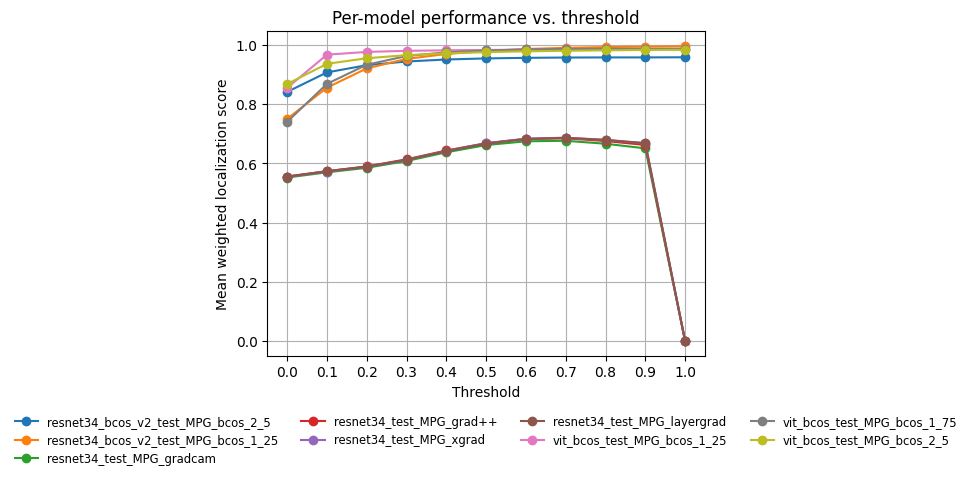

In [16]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

# ─────────── CONFIG ───────────
models = [
    "resnet34_bcos_v2_test_MPG_bcos_2_5",
    #"resnet34_bcos_v2_test_MPG_bcos_1_75",
    "resnet34_bcos_v2_test_MPG_bcos_1_25",
    #"resnet34_test_res_lime_config",
    "resnet34_test_MPG_gradcam",
    "resnet34_test_MPG_grad++",
    "resnet34_test_MPG_xgrad",
    "resnet34_test_MPG_layergrad",
    "vit_bcos_test_MPG_bcos_1_25",
    "vit_bcos_test_MPG_bcos_1_75",
    "vit_bcos_test_MPG_bcos_2_5"
    # ggf. weitere Modelle hier
]
results_base = "/pfs/work9/workspace/scratch/ma_tischuet-team_project_explainable_deepfakes/resultsMPG/"
grid_subpath  = "MaskPointingGame"
fname = "results_by_threshold.pkl"
# ─────────────────────────────────────────


plt.figure(figsize=(8,5))

for model_name in models:
    label = model_name
    pkl_path = os.path.join(results_base, model_name, "MaskPointingGame", fname)
    if not os.path.isfile(pkl_path):
        print(f"⚠️ missing {pkl_path}")
        continue

    # load grouped-by-threshold dict: { threshold: [entry, ...], ... }
    with open(pkl_path,'rb') as f:
        by_thr = pickle.load(f)

    # sort thresholds numerically
    threshs = sorted(by_thr.keys())
    mean_weighted = []
    #mean_unweighted = []

    for t in threshs:
        entries = by_thr[t]
        if not entries:
            mean_weighted.append(np.nan)
            #mean_unweighted.append(np.nan)
            continue

        w = [e["weighted_localization_score"]   for e in entries]
        #u = [e["unweighted_localization_score"] for e in entries]
        mean_weighted.append(np.mean(w))
        #mean_unweighted.append(np.mean(u))

    plt.plot(threshs, mean_weighted, marker='o', label=label)
    #plt.plot(threshs, mean_unweighted, linestyle='--', marker='x', label=model_name+" (unw.)")

plt.xticks(threshs)                       # Ticks bei 0.0,0.1,...,1.0
plt.xlabel("Threshold")
plt.ylabel("Mean weighted localization score")
plt.title("Per-model performance vs. threshold")
#plt.legend(loc="best", fontsize="small")
plt.legend(
    loc="upper center",              # Position relativ zum bbox_to_anchor
    bbox_to_anchor=(0.5, -0.15),     # (x, y) – x=0.5 Mitte, y<0 unterhalb der Achse
    ncol=4,                          # Anzahl Spalten in der Legende (anpassen!)
    fontsize="small",
    frameon=False
)
plt.grid(True)
plt.tight_layout()
plt.show()

Graph Unweighted localization score x treshhold (each on own data)

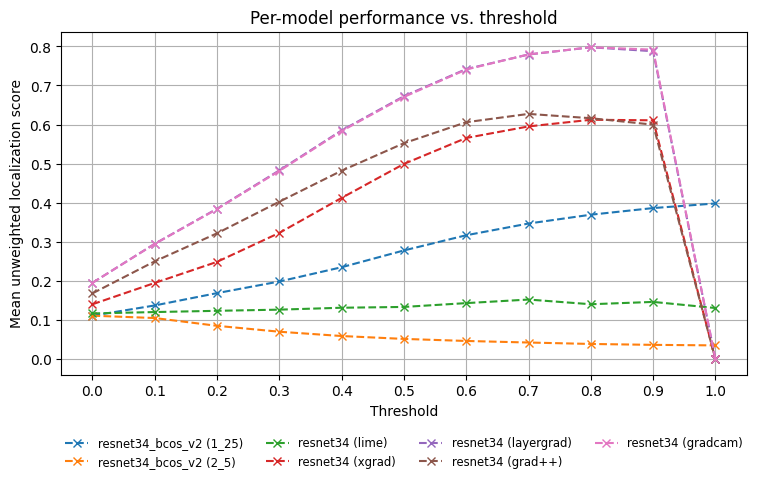

In [4]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

# ─────────── CONFIG ───────────
models = [
    "resnet34_bcos_v2_test_bcos_res_1_25_config",
    #"resnet34_bcos_v2_test_bcos_res_1_75_config",
    #"resnet34_bcos_v2_test_bcos_res_2_config",
    "resnet34_bcos_v2_test_bcos_res_2_5_config",
    "resnet34_test_res_lime_config",
    "resnet34_test_res_xgrad_config",
    "resnet34_test_res_layergrad_config",
    "resnet34_test_res_grad++_config",
    "resnet34_test_res_gradcam_config",
    # ggf. weitere Modelle hier
]
results_base = "/pfs/work9/workspace/scratch/ma_tischuet-team_project_explainable_deepfakes/resultsGPG"
grid_subpath  = "3x3"
fname         = "results_by_threshold.pkl"
# ─────────────────────────────────────────

def parse_folder_name(folder: str):
    """
    Aus 'resnet34_test_res_gradcam_config' → ('resnet34', 'gradcam')
    """
    assert folder.endswith("_config"), f"Erwarte Ordnername auf '_config' endend, got {folder}"
    core = folder[:-len("_config")]               # 'resnet34_bcos_v2_test_bcos_res_2_5'
    model, rest = core.split("_test_", 1)          # ['resnet34_bcos_v2', 'bcos_res_2_5']
    xai = rest.split("res_")[1:]
    return model, xai


plt.figure(figsize=(8,5))

for model_name in models:
    model, xai = parse_folder_name(model_name)
    label = f"{model} ({xai[0]})"
    pkl_path = os.path.join(results_base, model_name, grid_subpath, fname)
    if not os.path.isfile(pkl_path):
        print(f"⚠️ missing {pkl_path}")
        continue

    # load grouped-by-threshold dict: { threshold: [entry, ...], ... }
    with open(pkl_path,'rb') as f:
        by_thr = pickle.load(f)

    # sort thresholds numerically
    threshs = sorted(by_thr.keys())
    #mean_weighted = []
    mean_unweighted = []

    for t in threshs:
        entries = by_thr[t]
        if not entries:
            #mean_weighted.append(np.nan)
            mean_unweighted.append(np.nan)
            continue

        #w = [e["weighted_localization_score"]   for e in entries]
        u = [e["unweighted_localization_score"] for e in entries]
        #mean_weighted.append(np.mean(w))
        mean_unweighted.append(np.mean(u))

    #plt.plot(threshs, mean_weighted, marker='o', label=label)
    plt.plot(threshs, mean_unweighted, linestyle='--', marker='x', label=label)

plt.xticks(threshs)                       # Ticks bei 0.0,0.1,...,1.0
plt.xlabel("Threshold")
plt.ylabel("Mean unweighted localization score")
plt.title("Per-model performance vs. threshold")
#plt.legend(loc="best", fontsize="small")
plt.legend(
    loc="upper center",              # Position relativ zum bbox_to_anchor
    bbox_to_anchor=(0.5, -0.15),     # (x, y) – x=0.5 Mitte, y<0 unterhalb der Achse
    ncol=4,                          # Anzahl Spalten in der Legende (anpassen!)
    fontsize="small",
    frameon=False
)
plt.grid(True)
plt.tight_layout()
plt.show()

Graph Weighted localization score x treshhold (each on pooled data)

In [ ]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

# ─────────── CONFIG ───────────
models = [
    "resnet34_bcos_v2_test_bcos_res_1_25_config",
    #"resnet34_bcos_v2_test_bcos_res_1_75_config",
    #"resnet34_bcos_v2_test_bcos_res_2_config",
    "resnet34_bcos_v2_test_bcos_res_2_5_config",
    "resnet34_test_res_lime_config",
    "resnet34_test_res_xgrad_config",
    "resnet34_test_res_layergrad_config",
    "resnet34_test_res_grad++_config",
    "resnet34_test_res_gradcam_config",
    # ggf. weitere Modelle hier
]
results_base = "/pfs/work9/workspace/scratch/ma_tischuet-team_project_explainable_deepfakes/resultsGPG"
grid_subpath  = "3x3"
fname         = "results_by_threshold.pkl"
# ─────────────────────────────────────────

def parse_folder_name(folder: str):
    """
    Aus 'resnet34_test_res_gradcam_config' → ('resnet34', 'gradcam')
    """
    assert folder.endswith("_config"), f"Erwarte Ordnername auf '_config' endend, got {folder}"
    core = folder[:-len("_config")]               # 'resnet34_bcos_v2_test_bcos_res_2_5'
    model, rest = core.split("_test_", 1)          # ['resnet34_bcos_v2', 'bcos_res_2_5']
    xai = rest.split("res_")[1:]
    return model, xai


plt.figure(figsize=(8,5))

for model_name in models:
    model, xai = parse_folder_name(model_name)
    label = f"{model} ({xai[0]})"
    pkl_path = os.path.join(results_base, model_name, grid_subpath, fname)
    if not os.path.isfile(pkl_path):
        print(f"⚠️ missing {pkl_path}")
        continue

    # load grouped-by-threshold dict: { threshold: [entry, ...], ... }
    with open(pkl_path,'rb') as f:
        by_thr = pickle.load(f)

    # sort thresholds numerically
    threshs = sorted(by_thr.keys())
    mean_weighted = []
    #mean_unweighted = []

    for t in threshs:
        entries = by_thr[t]
        if not entries:
            mean_weighted.append(np.nan)
            #mean_unweighted.append(np.nan)
            continue

        w = [e["weighted_localization_score"]   for e in entries]
        #u = [e["unweighted_localization_score"] for e in entries]
        mean_weighted.append(np.mean(w))
        #mean_unweighted.append(np.mean(u))

    plt.plot(threshs, mean_weighted, marker='o', label=label)
    #plt.plot(threshs, mean_unweighted, linestyle='--', marker='x', label=model_name+" (unw.)")

plt.xticks(threshs)                       # Ticks bei 0.0,0.1,...,1.0
plt.xlabel("Threshold")
plt.ylabel("Mean weighted localization score")
plt.title("Per-model performance vs. threshold")
#plt.legend(loc="best", fontsize="small")
plt.legend(
    loc="upper center",              # Position relativ zum bbox_to_anchor
    bbox_to_anchor=(0.5, -0.15),     # (x, y) – x=0.5 Mitte, y<0 unterhalb der Achse
    ncol=4,                          # Anzahl Spalten in der Legende (anpassen!)
    fontsize="small",
    frameon=False
)
plt.grid(True)
plt.tight_layout()
plt.show()